In [97]:
import sys; sys.path.insert(0, '../../'); sys.path.insert(0,'../../../mac/ndtest/')
from ccqe_notebook_tools import * 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib notebook
# %matplotlib

# optimization of the box dimensions for $\frac{\Delta Q_{track}}{\Delta Q_{total}}$ 

In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/RdQaroundVertex/Figures/BoxOptimization/'

# pairs of 2-tracks at close proximity

In [3]:
pairs = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/ccqe_candidates/prodgenie_bnb_nu_uboone_overlay_reco2_vertices.csv')
pairsFV = sample_in_FV(pairs)
print len(pairs),'pairs from MC-BNB + cosmic DATA overlay'
print len(pairsFV),'pairs in FV'
samples=dict()
for pair_type in pair_types:
    samples[pair_type] = pairsFV[pairsFV[pair_type]==True]
    Ntype = len(samples[pair_type])
    if pair_type=='CC 1p 0pi': print_line()
    print Ntype,'are '+pair_type+', %.1f'%(100.*float(Ntype)/len(pairsFV))+'%'

19227 pairs from MC-BNB + cosmic DATA overlay
11435 pairs in FV
1441 are 1mu-1p, 12.6%
1462 are other pairs, 12.8%
8532 are cosmic, 74.6%
--------------------------------------------------------------
466 are CC 1p 0pi, 4.1%


In [4]:
N_box_sizes = 30
MinNwiresBox = 5
dNwiresBox = 5
MinNticksBox = 10
dNticksBox = 10
NwiresBox,NticksBox=[],[]
for i_box_size in range(N_box_sizes):
    NwiresBox.append(MinNwiresBox + i_box_size * dNwiresBox)
    NticksBox.append(MinNticksBox + i_box_size * dNticksBox) 

# an example of a 3D scatter plot of  $\frac{\Delta Q_{track}}{\Delta Q_{total}}$ in $(U,V,Y)$ planes

In [64]:
i_box_size = 10
RdQ_xyz, RdQ_3D_array = dict(), dict()

for i_pair_type in range(4):
    pair_type = pair_types[i_pair_type]; color=colors[i_pair_type]; label=labels[i_pair_type]; sample = samples[pair_type]     

    varx = 'RdQaroundVertex[plane 0][%d wires x %d ticks]'%(NwiresBox[i_box_size],NticksBox[i_box_size])
    vary = 'RdQaroundVertex[plane 1][%d wires x %d ticks]'%(NwiresBox[i_box_size],NticksBox[i_box_size])
    varz = 'RdQaroundVertex[plane 2][%d wires x %d ticks]'%(NwiresBox[i_box_size],NticksBox[i_box_size])

    sample = sample[(sample[varx]>-0.01)&(sample[vary]>-0.01)&(sample[varz]>-0.01)]
    x,y,z = sample[varx], sample[vary], sample[varz]
    RdQ_xyz[pair_type] = (x,y,z)
    RdQ_3D_array[pair_type] = np.array([[x_p,y_p,z_p] for x_p,y_p,z_p in zip(x,y,z)])
    print "created a 3D array for",pair_type

created a 3D array for 1mu-1p
created a 3D array for other pairs
created a 3D array for cosmic
created a 3D array for CC 1p 0pi


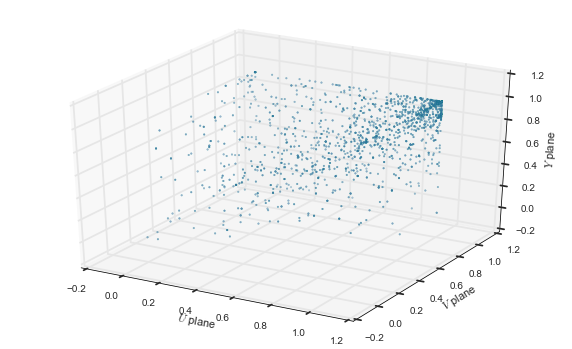

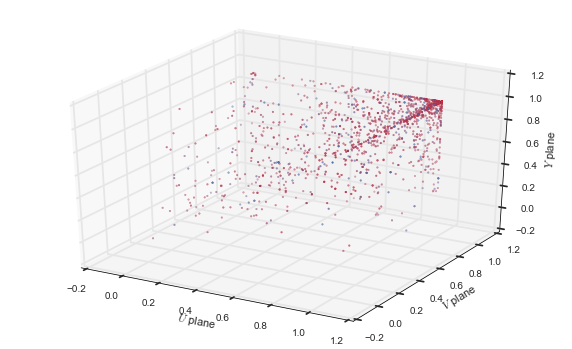

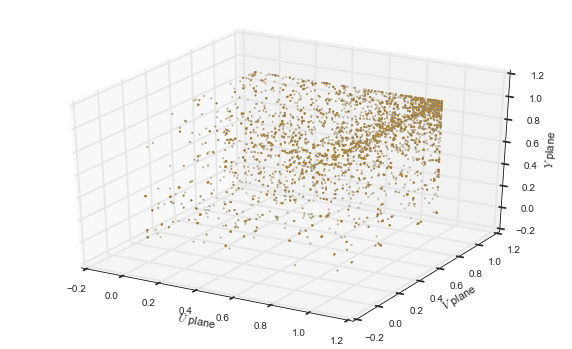

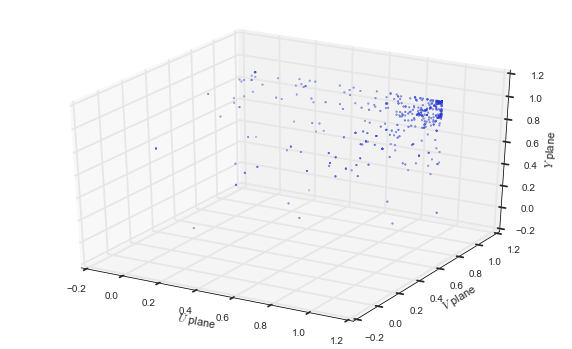

In [6]:
for i_pair_type in range(4):
    pair_type = pair_types[i_pair_type]; color=colors[i_pair_type]; label=labels[i_pair_type]; sample = samples[pair_type]     
    x, y, z = RdQ_xyz[pair_type]
    fig3D = plt.figure(figsize=(10,6)).gca(projection='3d')
    fig3D.scatter( x , y , z , color=color  , s=3)
    fig3D.set_xlabel('$U$ plane')
    fig3D.set_ylabel('$V$ plane')
    fig3D.set_zlabel('$Y$ plane')

# compare between 3D distributions: 
We want to find the optimal box dimensions by the ones with the largest difference (separation of CCQE from others)
in order to do that we compare between distributions using the 3D energy test

In [11]:
# RdQ_3D_array['1mu-1p']
# print RdQ_3D_array['CC 1p 0pi']
energy( RdQ_3D_array['1mu-1p'],RdQ_3D_array['CC 1p 0pi'] )

nan

In [65]:
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import genextreme



# def estat(x, y, nboot=1000, replace=False, method='log', fitting=False, debug=0):
#     if debug: print "estat(x, y, nboot=1000, replace=False, method='log', fitting=False)"

#     '''
#     Energy distance statistics test.
#     Reference
#     ---------
#     Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
#       multivariate goodness-of-fit tests, two-sample comparison and unfolding.
#       Nuc Instr and Meth in Phys Res A 537: 626-636
#     Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
#       based on distances. J Stat Planning & Infer 143: 1249-1272
#     Brian Lau, multdist, https://github.com/brian-lau/multdist

#     '''
#     n, N = len(x), len(x) + len(y)
#     stack = np.vstack([x, y])
#     stack = (stack - stack.mean(0)) / stack.std(0)
#     if replace:
#         rand = lambda x: random.randint(x, size=x)
#     else:
#         rand = random.permutation

#     en = energy(stack[:n], stack[n:], method)
#     en_boot = np.zeros(nboot, 'f')
#     for i in range(nboot):
#         idx = rand(N)
#         en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

#     if fitting:
#         param = genextreme.fit(en_boot)
#         p = genextreme.sf(en, *param)
#         return p, en, param
#     else:
#         p = (en_boot >= en).sum() / nboot
#         return p, en, en_boot


def Etest(x, y, method='log', epsilon=0.0001 ,debug=0):
    '''
     Energy distance statistics test.
     Reference
     ---------
     Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
       multivariate goodness-of-fit tests, two-sample comparison and unfolding.
       Nuc Instr and Meth in Phys Res A 537: 626-636
     Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
       based on distances. J Stat Planning & Infer 143: 1249-1272
     Brian Lau, multdist, https://github.com/brian-lau/multdist
     ---------
    Parameters: x: np.array()
                y:  np.array()
                method: method for energy-test function calculation
                        'log' : ln(r+ε)
                epsilon: for method 'log', this is the cutoff ε
                
    Returns:    Psi: ln(r(xy)+ε)/Nx*Ny - ln(r(xx)+ε)/Nx*Nx - ln(r(yy)+ε)/Ny*Ny
    '''
    if debug: print "energy(x, y, method='log')"
    r_xx, r_yy, r_xy = pdist(x), pdist(y), cdist(x, y)
    if debug:
        print "dx:",r_xx,'\n log(r_xx+ε):',np.log(r_xx+epsilon)
        print "r_yy:",r_yy,'\n log(r_yy+ε):',np.log(r_yy+epsilon)
        print "r_xy:",r_xy,'\n log(r_xy+ε):',np.log(r_xy+epsilon)
        
    Nx, Ny = len(x), len(y)
    
    if method == 'log':
        log_r_xx, log_r_yy, log_r_xy = np.log(r_xx+epsilon), np.log(r_yy+epsilon), np.log(r_xy+epsilon)
        Psi = log_r_xy.sum() / (Nx*Ny) - log_r_xx.sum() / (Nx*Nx) - log_r_yy.sum() / (Ny*Ny)
        
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
        
    return Psi

In [60]:
x=np.array([[0.,1.,1.],[0.,2.2,1.],[0.,1.4,1.2],[10.,1.4,1.2],[10.,14.,1.2]])
y=np.array([[0.,1.,1.05],[0.,2.,1.],[0.,1.4,1.25],[0.2,0.4,1.2]])
y_close=np.array([[0.,1.,1.051],[0.,2.,1.01],[0.,1.4,1.26],[0.2,0.4,1.21]])
print "energy(x, y, debug=0):",energy(x, y, debug=0)
print "energy(y, y_close, debug=0):",energy(y, y_close, debug=0)


energy(x, y, debug=0): -0.0603350848024
energy(y, y_close, debug=0): -1.28735912288


In [63]:
print "energy(RdQ_3D_array['1mu-1p'], RdQ_3D_array['CC 1p 0pi'], debug=1):",energy(RdQ_3D_array['1mu-1p'], RdQ_3D_array['CC 1p 0pi'], debug=0)
print "energy(RdQ_3D_array['cosmic'], RdQ_3D_array['CC 1p 0pi'], debug=1):",energy(RdQ_3D_array['cosmic'], RdQ_3D_array['CC 1p 0pi'], debug=0)

energy(RdQ_3D_array['1mu-1p'], RdQ_3D_array['CC 1p 0pi'], debug=1): 0.105896580207
energy(RdQ_3D_array['cosmic'], RdQ_3D_array['CC 1p 0pi'], debug=1): 0.159362370947


In [82]:
def Etest_CC1p0pi_vs_other_pair_types_per_box_size( i_box_size = 0 , debug=0 ):

    RdQ_xyz, RdQ_3D_array = dict(), dict()

    for i_pair_type in range(4):
        pair_type = pair_types[i_pair_type]; sample = samples[pair_type]     

        varx = 'RdQaroundVertex[plane 0][%d wires x %d ticks]'%(NwiresBox[i_box_size],NticksBox[i_box_size])
        vary = 'RdQaroundVertex[plane 1][%d wires x %d ticks]'%(NwiresBox[i_box_size],NticksBox[i_box_size])
        varz = 'RdQaroundVertex[plane 2][%d wires x %d ticks]'%(NwiresBox[i_box_size],NticksBox[i_box_size])

        sample = sample[(sample[varx]>-0.01)&(sample[vary]>-0.01)&(sample[varz]>-0.01)]
        x,y,z = sample[varx], sample[vary], sample[varz]
        RdQ_xyz[pair_type] = (x,y,z)
        RdQ_3D_array[pair_type] = np.array([[x_p,y_p,z_p] for x_p,y_p,z_p in zip(x,y,z)])
        if debug>1: print "created a 3D array for",pair_type
        
    PsiEtest = dict()
    for pair_type in (pair_types[0:3]):
        PsiEtest[pair_type+'/'+'CC 1p 0pi'] = Etest( RdQ_3D_array[pair_type], RdQ_3D_array['CC 1p 0pi'], debug=debug-1 )
    if debug: 
        print 'box size: [%d wires x %d ticks]'%(NwiresBox[i_box_size],NticksBox[i_box_size])
        print PsiEtest
    return PsiEtest

In [75]:
Etest_CC1p0pi_vs_other_pair_types_per_box_size( i_box_size = 7 , debug = 1 )

created a 3D array for 1mu-1p
created a 3D array for other pairs
created a 3D array for cosmic
created a 3D array for CC 1p 0pi
box size: [40 wires x 80 ticks]
{'1mu-1p/CC 1p 0pi': 0.10443096293589715, 'other pairs/CC 1p 0pi': 0.082981001222181883, 'cosmic/CC 1p 0pi': 0.1422780173768774}


In [83]:
debug = 1
box_size_indices = []
pd_Etest_results = pd.DataFrame()
for i_box_size in range(N_box_sizes):
    box_size_indices.append(i_box_size)
    PsiEtest = Etest_CC1p0pi_vs_other_pair_types_per_box_size( i_box_size , debug=debug )
    pd_Etest = pd.DataFrame({'box dimensions':'%d wires$\\times$%d ticks'%(NwiresBox[i_box_size],NticksBox[i_box_size])
                             ,'1mu-1p/CC 1p 0pi':PsiEtest['1mu-1p/CC 1p 0pi']
                             ,'other pairs/CC 1p 0pi':PsiEtest['other pairs/CC 1p 0pi']
                             ,'cosmic/CC 1p 0pi':PsiEtest['cosmic/CC 1p 0pi']}
                            ,index=[i_box_size])
    pd_Etest_results = pd_Etest_results.append(pd_Etest)
    
pd_Etest_results

box size: [5 wires x 10 ticks]
{'1mu-1p/CC 1p 0pi': 0.042987813185936696, 'other pairs/CC 1p 0pi': 0.038159568980585479, 'cosmic/CC 1p 0pi': 0.054172486718105706}
box size: [10 wires x 20 ticks]
{'1mu-1p/CC 1p 0pi': 0.062414669176934057, 'other pairs/CC 1p 0pi': 0.024447437864079657, 'cosmic/CC 1p 0pi': 0.019697165709887332}
box size: [15 wires x 30 ticks]
{'1mu-1p/CC 1p 0pi': 0.08127847472315064, 'other pairs/CC 1p 0pi': 0.040593153436582208, 'cosmic/CC 1p 0pi': 0.046904229956097776}
box size: [20 wires x 40 ticks]
{'1mu-1p/CC 1p 0pi': 0.086046348808166306, 'other pairs/CC 1p 0pi': 0.048263613367066194, 'cosmic/CC 1p 0pi': 0.079804467503245213}
box size: [25 wires x 50 ticks]
{'1mu-1p/CC 1p 0pi': 0.085913048597427211, 'other pairs/CC 1p 0pi': 0.055510145484299778, 'cosmic/CC 1p 0pi': 0.099944231145841944}
box size: [30 wires x 60 ticks]
{'1mu-1p/CC 1p 0pi': 0.0965320531935282, 'other pairs/CC 1p 0pi': 0.069632327059290122, 'cosmic/CC 1p 0pi': 0.12266965698889221}
box size: [35 wires x

,1mu-1p/CC 1p 0pi,box dimensions,cosmic/CC 1p 0pi,other pairs/CC 1p 0pi
0,0.042988,[5 wires x 10 ticks],0.054172,0.038160
1,0.062415,[10 wires x 20 ticks],0.019697,0.024447
2,0.081278,[15 wires x 30 ticks],0.046904,0.040593
3,0.086046,[20 wires x 40 ticks],0.079804,0.048264
4,0.085913,[25 wires x 50 ticks],0.099944,0.055510
5,0.096532,[30 wires x 60 ticks],0.122670,0.069632
6,0.097228,[35 wires x 70 ticks],0.127800,0.070735
7,0.104431,[40 wires x 80 ticks],0.142278,0.082981
8,0.103933,[45 wires x 90 ticks],0.146815,0.087623
9,0.106747,[50 wires x 100 ticks],0.155693,0.095476


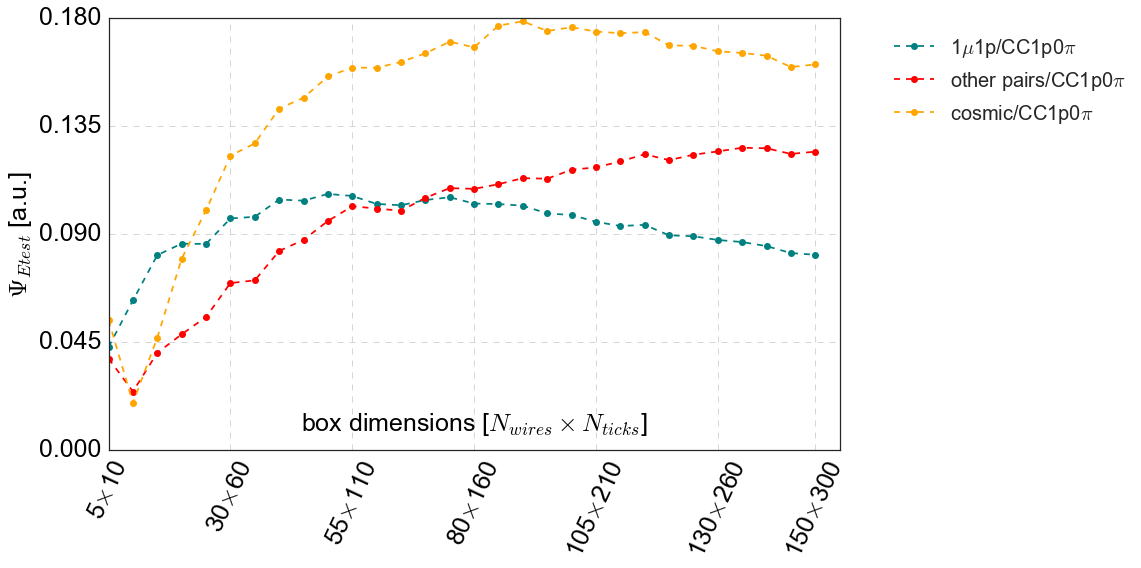

In [126]:
fig,ax=plt.subplots(figsize=(12,8))
for i_pair_type in range(3):
    pair_type=pair_types[i_pair_type];color=colors[i_pair_type];label=labels[i_pair_type]
    y = pd_Etest_results[pair_type+'/'+'CC 1p 0pi'];
    plt.plot( y , '--o' , color=color , label=label+'/CC1p0$\pi$')
# plt.legend(loc='lower center',fontsize=20)
leg=plt.legend(bbox_to_anchor=(1.05,1),loc=2,fontsize=20)
xticks=[0,5,10,15,20,25,29]
set_axes( ax , 'box dimensions [$N_{wires} \\times N_{ticks}$]' , '$\Psi_{Etest}$ [a.u.]',xticks=xticks ,do_add_grid=True)
ax.yaxis.set_major_locator(LinearLocator(5))
tick_labels = [item.get_text() for item in ax.get_xticklabels()]
# tick_labels[0] = pd_Etest_results['box dimensions'][0]
for i,i_box_size in enumerate(xticks):
    tick_labels[i] = '%d$\\times$%d'%(NwiresBox[i_box_size],NticksBox[i_box_size])
ax.set_xticklabels(tick_labels, rotation=65);
ax.xaxis.labelpad = -150
plt.tight_layout()
plt.savefig(figures_path+'EtestPsi_vs_box_dimensions.pdf',bbox_extra_artists=(leg,), bbox_inches='tight')